In [2]:
import tensorflow as tf
# GPU memory growth configuration
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

**Dataset details**

The dataset contains two classes - REAL and FAKE.

For REAL, we collected the images from Krizhevsky & Hinton's CIFAR-10 dataset

For the FAKE images, we generated the equivalent of CIFAR-10 with Stable Diffusion version 1.4

There are 100,000 images for training (50k per class) and 20,000 for testing (10k per class)

# Load the dataset

In [3]:
import numpy as np
import os
import cv2
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator

# Define paths to the train and test directories
train_dir_real = '/kaggle/input/cifake-real-and-ai-generated-synthetic-images/train/REAL'
train_dir_fake = '/kaggle/input/cifake-real-and-ai-generated-synthetic-images/train/FAKE'
test_dir_real = '/kaggle/input/cifake-real-and-ai-generated-synthetic-images/test/REAL'
test_dir_fake = '/kaggle/input/cifake-real-and-ai-generated-synthetic-images/test/FAKE'

# Function to load images and labels
def load_images_and_labels(directory, label):
    images = []
    labels = []
    for filename in os.listdir(directory):
        img_path = os.path.join(directory, filename)
        img = cv2.imread(img_path)
        img = cv2.resize(img, (32, 32)) 
        images.append(img)
        labels.append(label)
    return images, labels

# Load REAL train images and labels
real_train_images, real_train_labels = load_images_and_labels(train_dir_real, label=0)

# Load FAKE train images and labels
fake_train_images, fake_train_labels = load_images_and_labels(train_dir_fake, label=1)

# Load REAL test images and labels
real_test_images, real_test_labels = load_images_and_labels(test_dir_real, label=0)

# Load FAKE test images and labels
fake_test_images, fake_test_labels = load_images_and_labels(test_dir_fake, label=1)

# Concatenate REAL and FAKE train/test data and labels
X_train = np.concatenate((real_train_images, fake_train_images), axis=0)
y_train = np.concatenate((real_train_labels, fake_train_labels), axis=0)
X_test = np.concatenate((real_test_images, fake_test_images), axis=0)
y_test = np.concatenate((real_test_labels, fake_test_labels), axis=0)

# Convert labels to one-hot encoding
y_train = np.eye(2)[y_train]
y_test = np.eye(2)[y_test]

# Normalize image data
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# Create an instance of ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=40,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Fit the ImageDataGenerator on the training data
datagen.fit(X_train)

# Shuffle the order of REAL and FAKE train data
shuffled_indices_train = np.arange(X_train.shape[0])
np.random.shuffle(shuffled_indices_train)

# Use the same set of shuffled indices for both images and labels
X_train = X_train[shuffled_indices_train]
y_train = y_train[shuffled_indices_train]

# Shuffle the order of REAL and FAKE test data
shuffled_indices_test = np.arange(X_test.shape[0])
np.random.shuffle(shuffled_indices_test)

# Use the same set of shuffled indices for both images and labels
X_test = X_test[shuffled_indices_test]
y_test = y_test[shuffled_indices_test]

# 1. Checking dataset for images and labels


In [4]:
print("Total number of REAL images in y_train:", np.sum(y_train[:, 0]))
print("Total number of FAKE images in y_train:", np.sum(y_train[:, 1]))

print("Number of REAL images in the first 50000 samples:", np.sum(y_train[:50000, 0]))
print("Number of FAKE images in the first 50000 samples:", np.sum(y_train[:50000, 1]))

print("Number of REAL images in the second 50000 samples:", np.sum(y_train[50000:, 0]))
print("Number of FAKE images in the second 50000 samples:", np.sum(y_train[50000:, 1]))

Total number of REAL images in y_train: 50000.0
Total number of FAKE images in y_train: 50000.0
Number of REAL images in the first 50000 samples: 24874.0
Number of FAKE images in the first 50000 samples: 25126.0
Number of REAL images in the second 50000 samples: 25126.0
Number of FAKE images in the second 50000 samples: 24874.0


In [5]:
print("Total number of REAL images in y_test:", np.sum(y_test[:, 0]))
print("Total number of FAKE images in y_test:", np.sum(y_test[:, 1]))

print("Number of REAL images in the first 10000 samples:", np.sum(y_test[:10000, 0]))
print("Number of FAKE images in the first 10000 samples:", np.sum(y_test[:10000, 1]))

print("Number of REAL images in the second 10000 samples:", np.sum(y_test[10000:, 0]))
print("Number of FAKE images in the second 10000 samples:", np.sum(y_test[10000:, 1]))

Total number of REAL images in y_test: 10000.0
Total number of FAKE images in y_test: 10000.0
Number of REAL images in the first 10000 samples: 5012.0
Number of FAKE images in the first 10000 samples: 4988.0
Number of REAL images in the second 10000 samples: 4988.0
Number of FAKE images in the second 10000 samples: 5012.0


# VGG19 model

In [11]:
from keras.applications.vgg19 import VGG19
from keras import layers, models, optimizers
from keras.callbacks import EarlyStopping
from keras.optimizers import Nadam

vgg19_weights_path = "/kaggle/input/vgg19-weights/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5"

vgg19_model = VGG19(weights=vgg19_weights_path, include_top=False, input_shape=(32, 32, 3))

# Freeze convolutional layers
for layer in vgg19_model.layers:
    layer.trainable = False

# Build a custom model on top of VGG19
model_vgg19 = models.Sequential([
    vgg19_model,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(2, activation='softmax')
])

In [18]:
# Compile the VGG19 model with Nadam optimizer
model_vgg19.compile(optimizer=Nadam(learning_rate=0.0001),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

# Implement early stopping for VGG19
early_stopping_vgg19 = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [19]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

In [28]:
# Train the VGG19 model
history_vgg19 = model_vgg19.fit(
    datagen.flow(X_train, y_train, batch_size=100),
    epochs=15,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping_vgg19]
)

Epoch 1/15
1000/1000 [==============================] - 597s 597ms/step - loss: 0.4286 - accuracy: 0.8023 - val_loss: 0.3897 - val_accuracy: 0.8248
Epoch 2/15
1000/1000 [==============================] - 598s 598ms/step - loss: 0.4171 - accuracy: 0.8083 - val_loss: 0.3910 - val_accuracy: 0.8221
Epoch 3/15
1000/1000 [==============================] - 596s 596ms/step - loss: 0.4067 - accuracy: 0.8149 - val_loss: 0.3798 - val_accuracy: 0.8272
Epoch 4/15
1000/1000 [==============================] - 598s 598ms/step - loss: 0.4009 - accuracy: 0.8179 - val_loss: 0.3740 - val_accuracy: 0.8314
Epoch 5/15
1000/1000 [==============================] - 593s 593ms/step - loss: 0.3961 - accuracy: 0.8201 - val_loss: 0.3684 - val_accuracy: 0.8342
Epoch 6/15
1000/1000 [==============================] - 597s 597ms/step - loss: 0.3914 - accuracy: 0.8217 - val_loss: 0.3710 - val_accuracy: 0.8318
Epoch 7/15
1000/1000 [==============================] - 596s 596ms/step - loss: 0.3873 - accuracy: 0.8261 - val_

In [30]:

last_epoch = len(history_vgg19.history['accuracy'])

# Print the information for the last epoch
print("Last Epoch:")
print(f"Training Accuracy: {history_vgg19.history['accuracy'][last_epoch - 1]:.4f}")
print(f"Validation Accuracy: {history_vgg19.history['val_accuracy'][last_epoch - 1]:.4f}")
print(f"Training Loss: {history_vgg19.history['loss'][last_epoch - 1]:.4f}")
print(f"Validation Loss: {history_vgg19.history['val_loss'][last_epoch - 1]:.4f}")


Last Epoch:
Training Accuracy: 0.8372
Validation Accuracy: 0.8464
Training Loss: 0.3668
Validation Loss: 0.3426


<Axes: >

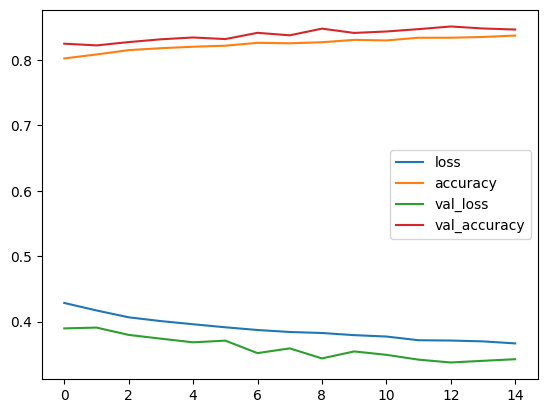

In [31]:
import pandas as pd
pd.DataFrame(history_vgg19.history).plot()

625/625 [==============================] - 105s 168ms/step


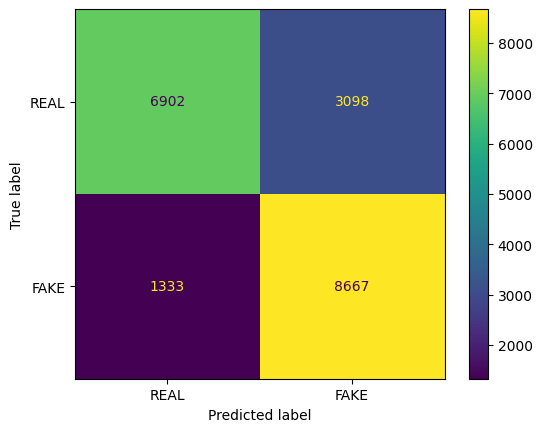

In [32]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predictions on test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Calculate confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes, labels=[0, 1])

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["REAL", "FAKE"])
disp.plot(cmap='viridis', values_format='d')
plt.show()


In [33]:
from sklearn.metrics import classification_report

# Classification report
print(classification_report(y_true_classes, y_pred_classes, target_names=["REAL", "FAKE"]))


              precision    recall  f1-score   support

        REAL       0.84      0.69      0.76     10000
        FAKE       0.74      0.87      0.80     10000

    accuracy                           0.78     20000
   macro avg       0.79      0.78      0.78     20000
weighted avg       0.79      0.78      0.78     20000



625/625 [==============================] - 109s 174ms/step
Sample Order:
[0 0 1 1 1 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 1]
Predictions Order:
[0 0 1 1 1 0 0 0 0 0 0 1 0 0 1 1 0 0 0 1 1]


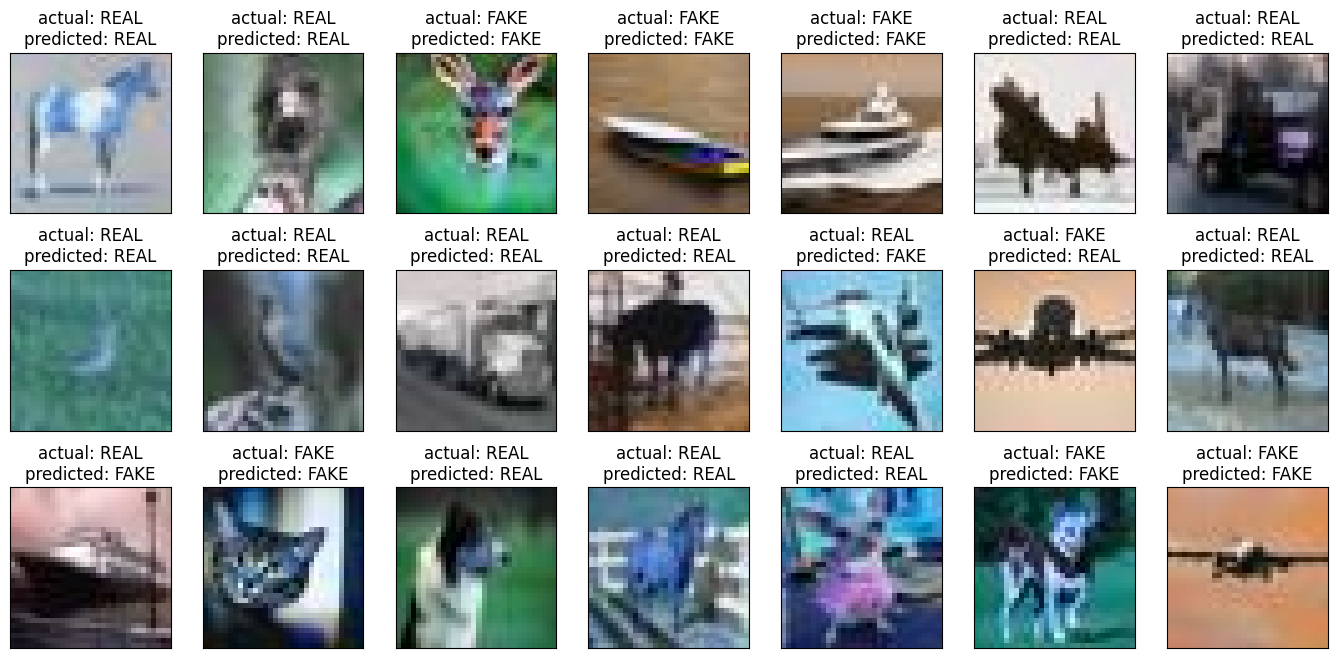

In [34]:
predictions = model.predict(X_test)
labels = ["REAL", "FAKE"]

fig, axes = plt.subplots(ncols=7, nrows=3, sharex=False,
    sharey=True, figsize=(17, 8))
index = 0
for i in range(3):
    for j in range(7):
        actual_label = labels[np.argmax(y_test[index])]
        predicted_label = labels[np.argmax(predictions[index])]
        axes[i, j].set_title(f'actual: {actual_label}\npredicted: {predicted_label}')
        axes[i, j].imshow(X_test[index], cmap='gray')
        axes[i, j].get_xaxis().set_visible(False)
        axes[i, j].get_yaxis().set_visible(False)
        index += 1

# Add debug information
print("Sample Order:")
print(np.argmax(y_test[:21], axis=1))
print("Predictions Order:")
print(np.argmax(predictions[:21], axis=1))

plt.show()


In [35]:
predictions = model.predict(X_test)
for i in range(10):
    actual_label = labels[np.argmax(y_test[i])]
    predicted_label = labels[np.argmax(predictions[i])]
    print(f'Sample {i + 1} - Actual: {actual_label}, Predicted: {predicted_label}')

625/625 [==============================] - 107s 171ms/step
Sample 1 - Actual: REAL, Predicted: REAL
Sample 2 - Actual: REAL, Predicted: REAL
Sample 3 - Actual: FAKE, Predicted: FAKE
Sample 4 - Actual: FAKE, Predicted: FAKE
Sample 5 - Actual: FAKE, Predicted: FAKE
Sample 6 - Actual: REAL, Predicted: REAL
Sample 7 - Actual: REAL, Predicted: REAL
Sample 8 - Actual: REAL, Predicted: REAL
Sample 9 - Actual: REAL, Predicted: REAL
Sample 10 - Actual: REAL, Predicted: REAL
